# Capstone Project - The Battle of the Neighborhoods
## Applied Data Science Capstone by IBM/Coursera¶

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

   In this project, we are trying to find a solution to the stakeholders that want to open a Thai Restaurant in Frankfurt.

Since there are lots of parameters to find a best place to open a Thai Restaurant, we can use data science techniques to handle with this problem.

Especially important facts that must be considered are;
-	How many restaurants are in a special neighbourhood?
-	What type of restaurants are there?
-	Is a neighbourhood special or not regarding people’s culture who lives there? (For example there can be  a lot of Thai restaurants in the neighbourhood where mostly people with asian culture live)


## Data <a name="data"></a>

We will use;
- Pgeocode api to get the coordinates of the neighbourhoods in Frankfurt.
- Foursquare api to get the venues in Frankfurt.

Let's import libraries

In [1]:
!pip install pgeocode
!pip install folium
!pip install geopy

     |████████████████████████████████| 112kB 6.9MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import requests
import sys
from geopy.geocoders import Nominatim
import collections
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import radians, sin, cos, acos
import pgeocode
import folium

#### Example for how pgeocode works

As you can see below, pgeocode gives us the coordinates of neighbourhouds according to their postal codes.

In [3]:
nomi = pgeocode.Nominatim('de')
nomi.query_postal_code("60308")

postal_code                            60308
country_code                              DE
place_name                 Frankfurt am Main
state_name                            Hessen
state_code                                HE
county_name       Regierungsbezirk Darmstadt
county_code                               64
community_name      Frankfurt am Main, Stadt
community_code                          6412
latitude                             50.1125
longitude                             8.6529
accuracy                                   6
Name: 0, dtype: object

My postal_code list contains all 39 neighborhoods in Frankfurt.

In [4]:
postal_code = [60308, 60311, 60313, 60314, 60316, 60318, 60320, 60322, 60323, 60325, 60326, 60327, 60329, 60385, 60386, 60388, 60389, 60431, 60433, 60435, 60437, 60438, 
               60439, 60486, 60487, 60488, 60489, 60528, 60529, 60549, 60594, 60596, 60598, 60599, 65929, 65931, 65933, 65934, 65936]

In [5]:
len(postal_code)

39

Let's create an empty dataframe to put the coordinates of neighbourhoods.

In [6]:
d = {'postal_code': [], 'latitude': [],'longitude': []}
df = pd.DataFrame(data=d)
df.head()

,postal_code,latitude,longitude


In [7]:
for i in postal_code:
    i = str(i)
    lat = nomi.query_postal_code(i)['latitude']
    long = nomi.query_postal_code(i)['longitude']
    df = df.append({'postal_code': i, 'latitude': lat,'longitude': long}, ignore_index=True)    
    
df.head()   

,postal_code,latitude,longitude
0,60308,50.1125,8.6529
1,60311,50.1112,8.6831
2,60313,50.1153,8.6823
3,60314,50.1137,8.7119
4,60316,50.1209,8.6966


Now, we are ready to fetch data from foursquare API.

## Foursquare

In [73]:
CLIENT_ID = 'XX'  #your Foursquare ID
CLIENT_SECRET = 'XX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

Function to get the venues nearby the neighbourhood

In [9]:
LIMIT = 100
radius = 250

def getNearbyVenues(postal_code,latitudes, longitudes, radius=500):
    
    venues_list=[]
    for post, lat, lng in zip(postal_code, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            post,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['postal_code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
frankfurt_venues = getNearbyVenues(df['postal_code'],df['latitude'],df['longitude'])

In [11]:
frankfurt_venues.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,60308,50.1125,8.6529,Ramen Jun,50.113201,8.655861,Ramen Restaurant
1,60308,50.1125,8.6529,Grandhotel Hessischer Hof,50.112387,8.655588,Hotel
2,60308,50.1125,8.6529,Cucina Mediterraneo,50.111819,8.654621,Italian Restaurant
3,60308,50.1125,8.6529,Jewel of India,50.113025,8.655565,Indian Restaurant
4,60308,50.1125,8.6529,Kaffeewerk Espressionist,50.109975,8.655504,Café


We have 951 venues in Frankfurt.

In [12]:
frankfurt_venues.shape

(951, 7)

Let's look at our venues in Frankfurt.

In [13]:
frankfurt_venues['Venue Category'].value_counts()

Café                   66
Italian Restaurant     53
Hotel                  41
Supermarket            37
Bakery                 30
                       ..
Dim Sum Restaurant      1
Event Service           1
Friterie                1
Sporting Goods Shop     1
Comedy Club             1
Name: Venue Category, Length: 184, dtype: int64

Using folium library, I can visualize venues on the map. But firstly I need the coordinates of Frankfurt to center it on the map.

In [14]:
geolocator = Nominatim(user_agent='myapplication')
location = geolocator.geocode("Frankfurt")
frankfurt_center = [location.latitude,location.longitude]
print('Coordinates of Frankfurt is {} N {} S'.format(frankfurt_center[0],frankfurt_center[1])) 

Coordinates of Frankfurt is 50.1106444 N 8.6820917 S


In [15]:
map_frankfurt = folium.Map(location=frankfurt_center, zoom_start=13)
folium.Marker(frankfurt_center, popup='Frankfurt').add_to(map_frankfurt)
for lat, lon in zip(frankfurt_venues['Venue Latitude'], frankfurt_venues['Venue Longitude']):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_frankfurt) 
    folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_frankfurt)
    #folium.Marker([lat, lon]).add_to(map_frankfurt)
map_frankfurt

## Methodology <a name="methodology"></a>

In our case, Stakeholders are looking for a place to open a Thai Restaurant. So we take only the restaurants into consideration. 

In the first step, we will create a new dataframe that contains only restaurants. Then we determine the frequencies of restaurants. According to that, we implement k-means clustering to understand data better. Clustering shows us the specific neighbourhoods with specific restaurants. 

After clustering, we will decide where to open a Thai Restaurant according to some parameters like restaurant density of the neighbourhood, distance from Frankfurt Center etc.


## Analysis <a name="analysis"></a>

Let's look at the restaurant types.

In [16]:
rest_types = []
for i in frankfurt_venues['Venue Category']:
    if 'Restaurant' in i:
        if i not in rest_types:
            rest_types.append(i)

There are lots of restaurants types but one important point is that there are some restaurants without any specific category such as 'Middle Eastern', 'Swiss'.

In [17]:
rest_types

['Ramen Restaurant',
 'Italian Restaurant',
 'Indian Restaurant',
 'Mexican Restaurant',
 'Asian Restaurant',
 'Restaurant',
 'French Restaurant',
 'Swiss Restaurant',
 'Japanese Restaurant',
 'Seafood Restaurant',
 'Vietnamese Restaurant',
 'Sushi Restaurant',
 'German Restaurant',
 'Moroccan Restaurant',
 'Austrian Restaurant',
 'Tapas Restaurant',
 'American Restaurant',
 'Chinese Restaurant',
 'Thai Restaurant',
 'Doner Restaurant',
 'Turkish Restaurant',
 'Dim Sum Restaurant',
 'African Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Southern / Soul Food Restaurant',
 'North Indian Restaurant',
 'Modern European Restaurant',
 'Tibetan Restaurant',
 'Falafel Restaurant',
 'Mediterranean Restaurant',
 'Spanish Restaurant',
 'Portuguese Restaurant',
 'Middle Eastern Restaurant',
 'Ethiopian Restaurant',
 'Korean Restaurant',
 'Malay Restaurant',
 'Israeli Restaurant',
 'Fast Food Restaurant',
 'Czech Restaurant',
 'Eastern European Restaurant',
 'Kebab Restaurant',
 'Vege

First of all, I am creating an empty dataframe with the same columns to gather all restaurant into a single dataframe.

In [24]:
len(rest_types)

44

In [18]:
rest_df = pd.DataFrame(columns = frankfurt_venues.columns)
rest_df

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [19]:
for i in rest_types:
    df2 = frankfurt_venues[frankfurt_venues['Venue Category']==i]
    rest_df = rest_df.append(df2)
rest_df.reset_index(drop=True,inplace =True)
rest_df.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,60308,50.1125,8.6529,Ramen Jun,50.113201,8.655861,Ramen Restaurant
1,60308,50.1125,8.6529,Takumi,50.114437,8.657419,Ramen Restaurant
2,60325,50.1155,8.6596,Ramen Jun,50.113201,8.655861,Ramen Restaurant
3,60594,50.1039,8.6886,Muku,50.105927,8.692276,Ramen Restaurant
4,60308,50.1125,8.6529,Cucina Mediterraneo,50.111819,8.654621,Italian Restaurant


Now, I can see that there are only 306 restaurants out of 951 venues.

In [20]:
rest_df.shape

(306, 7)

Let's explore the frequencies of restaurant types.

In [25]:
grouped = rest_df.groupby(['Venue Category']).count()
grouped.sort_values('postal_code', ascending=False,inplace = True)
grouped.head(10)

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Italian Restaurant,53,53,53,53,53,53
Restaurant,23,23,23,23,23,23
German Restaurant,23,23,23,23,23,23
Thai Restaurant,21,21,21,21,21,21
Asian Restaurant,19,19,19,19,19,19
Vietnamese Restaurant,14,14,14,14,14,14
Japanese Restaurant,12,12,12,12,12,12
Falafel Restaurant,11,11,11,11,11,11
Sushi Restaurant,10,10,10,10,10,10


We will use top ten frequent restaurant types for clustering.

In [26]:
top_ten_rest = grouped.index[:10]
top_ten_rest.name = ''

In [27]:
top_ten_rest

Index(['Italian Restaurant', 'Restaurant', 'German Restaurant',
       'Thai Restaurant', 'Asian Restaurant', 'Vietnamese Restaurant',
       'Japanese Restaurant', 'Falafel Restaurant', 'Sushi Restaurant',
       'Indian Restaurant'],
      dtype='object', name='')

Now let's cluster the neighbourhoods in Frankfurt using top ten restaurant types.

First of all, I should create a new dataframe, with columns of ten different restaurant types and rows of neighbourhoods.

In [28]:
df_cluster = pd.DataFrame(columns = top_ten_rest)
df_cluster

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant


In this dataframe, I want to see how many restaurants are in a specific area by looking the row of that area.

In [29]:
for post in rest_df['postal_code'].unique():
    df_post = rest_df[rest_df['postal_code']== post]
    att = []
    for cat in top_ten_rest:
        att.append(np.sum(df_post['Venue Category'] == cat))
    df_cluster.loc[post] = att
    

In [30]:
df_cluster.head()

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant
60308,3,1,0,0,4,0,1,0,0,1
60325,4,1,0,0,0,0,1,0,0,1
60594,2,0,4,2,0,1,0,3,0,0
60311,1,4,3,0,0,1,0,0,1,0
60313,4,5,2,4,1,1,3,0,2,0


As you can see below, Total number of each restaurant types are equal to the total number in the previous dataframe.

In [31]:
df_cluster.sum(axis=0)


Italian Restaurant       53.0
Restaurant               23.0
German Restaurant        23.0
Thai Restaurant          21.0
Asian Restaurant         19.0
Vietnamese Restaurant    14.0
Japanese Restaurant      12.0
Falafel Restaurant       11.0
Sushi Restaurant         10.0
Indian Restaurant        10.0
dtype: float64

Now, Our dataset is ready for any machine learning algorithm. We will implement k-means clustering to see the different types of neighbourhoods. At first, We should find the best k for my model.

In [32]:
#### Elbow Method for Finding Optimal Number of Clusters

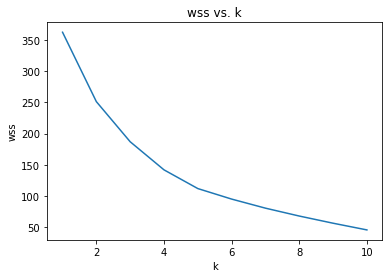

In [33]:
wss = [] # within sum of clusters
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster.values)
    wss.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1,11),wss)
plt.title('wss vs. k')
plt.ylabel('wss')
plt.xlabel('k')
plt.show()

As you can see, k = 5 is the elbow point in the graph. Then we will select k equals 5.

In [34]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_cluster.values)

Let's add the cluster lables to our dataset.

In [35]:
df_cluster['cluster_class'] = kmeans.labels_
df_cluster.head()

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class
60308,3,1,0,0,4,0,1,0,0,1,2
60325,4,1,0,0,0,0,1,0,0,1,2
60594,2,0,4,2,0,1,0,3,0,0,1
60311,1,4,3,0,0,1,0,0,1,0,1
60313,4,5,2,4,1,1,3,0,2,0,4


When we look at the total number of neighbourhoods in each cluster, Cluster 0 is the most frequent cluster as you can see below.

In [36]:
df_cluster.groupby(['cluster_class']).count()

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant
cluster_class,,,,,,,,,,
0,21,21,21,21,21,21,21,21,21,21
1,3,3,3,3,3,3,3,3,3,3
2,7,7,7,7,7,7,7,7,7,7
3,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1


Let's write a function to summarize all clusters.

In [37]:
def cluster_summary(k):
    for i in range(k):
        print('----------Cluster Summary {}-----------'.format(str(i)))
        print(df_cluster[df_cluster['cluster_class']==i].mean())
        total = df_cluster[df_cluster['cluster_class']==i].sum().sum()
        neigh = len(df_cluster[df_cluster['cluster_class']==i])
        avg = total/neigh
        print('Average restaurants for the cluster :', avg)
        print('Total number of neighbourhoods in the cluster:', neigh)

In [38]:
cluster_summary(5)

----------Cluster Summary 0-----------

Italian Restaurant       0.761905
Restaurant               0.142857
German Restaurant        0.285714
Thai Restaurant          0.190476
Asian Restaurant         0.285714
Vietnamese Restaurant    0.047619
Japanese Restaurant      0.142857
Falafel Restaurant       0.095238
Sushi Restaurant         0.047619
Indian Restaurant        0.000000
cluster_class            0.000000
dtype: float64
Average restaurants for the cluster : 2.0
Total number of neighbourhoods in the cluster: 21
----------Cluster Summary 1-----------

Italian Restaurant       1.333333
Restaurant               2.000000
German Restaurant        3.666667
Thai Restaurant          1.333333
Asian Restaurant         0.333333
Vietnamese Restaurant    1.000000
Japanese Restaurant      0.000000
Falafel Restaurant       1.666667
Sushi Restaurant         0.666667
Indian Restaurant        0.000000
cluster_class            1.000000
dtype: float64
Average restaurants for the cluster : 13.0
Total n

As you can see from the summary, 
    
   * While cluster 0 is so common, there is not many restaurants in that areas. So we can think that we don't suggest these neighbourhoods to the stakeholders.
   * Cluster 1 and 2 has more average restaurants than cluster 0. But it is really low when we compare with other clusters 3 and 4.
   * Cluster 4 has the highest average number of Thai Restaurants. So, maybe these neighbourhoods are places where Thai people live.
   * Cluster 3 has more restaurants than other Clusters. But there are a lot of restaurants without any specific category. So, this cluster needs more research. If we can be sure, that we have certain data, we can say, that here is the most probable place to open Thai restaurant. Because, this area is known for restaurants and the ratio of Thai restaurants is relatively low.
   * Even though cluster 4 has a lot of restaurants, it has a huge number of Italian Restaurants. I can assume that the people lives in those areas really like Italian cuisine. So opening a Thai restaurant in these neighbourhoods may not be a good idea.

In [39]:
df_cluster.sort_index(inplace=True)

In the plot below, we can see that there are 4 Thai Restaurants in neighbourhood with '60333' postal code. There can be many Thai people living. 

At first, opening a Thai restaurant in a Thai Borough or Borough with asian culture sounds logical but there are still a lot of Thai Restaurants. So If we open a Thai restaurant there, we must share the market and this is not wanted by stakeholders. Also you can see below that there are not only Thai restaurants in 60313.



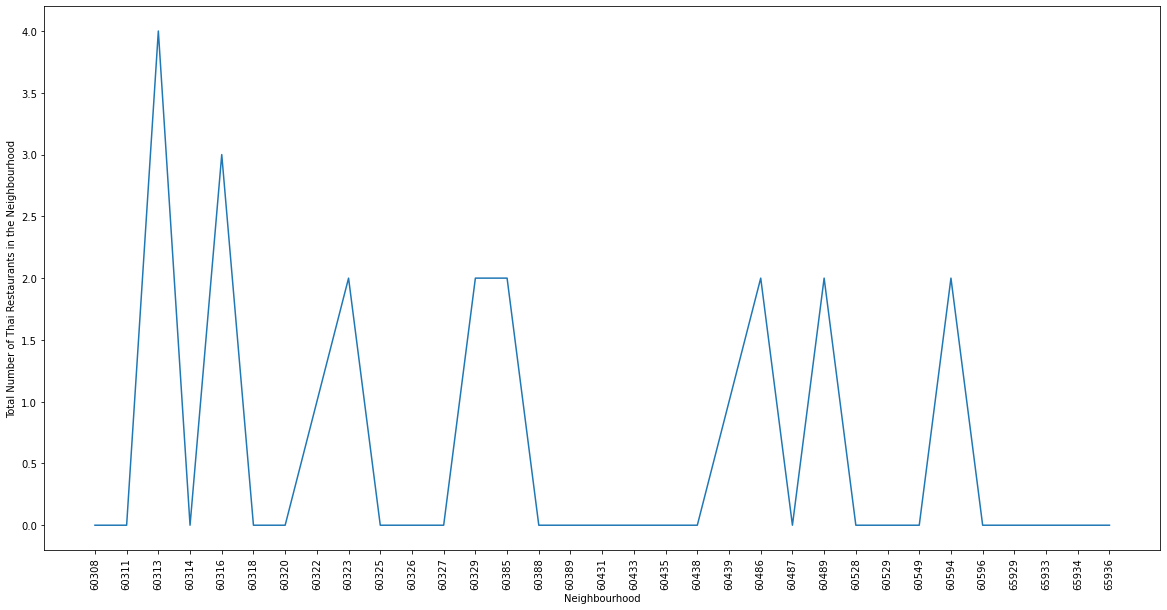

In [40]:
plt.figure(figsize = (20,10))
plt.plot(df_cluster['Thai Restaurant'])
plt.ylabel('Total Number of Thai Restaurants in the Neighbourhood')
plt.xlabel('Neighbourhood')
plt.xticks(rotation='vertical')
plt.show()

In [41]:
df_cluster.loc['60313',:]


Italian Restaurant       4
Restaurant               5
German Restaurant        2
Thai Restaurant          4
Asian Restaurant         1
Vietnamese Restaurant    1
Japanese Restaurant      3
Falafel Restaurant       0
Sushi Restaurant         2
Indian Restaurant        0
cluster_class            4
Name: 60313, dtype: object

To better understand the clustering, let's visualize it with folium map.

First, we need coordinates again.

In [42]:
for i in df_cluster.index:
    df_cluster.loc[i,'latitude'] = nomi.query_postal_code(i)['latitude']
    df_cluster.loc[i,'longitude'] = nomi.query_postal_code(i)['longitude']
df_cluster.head()   

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class,latitude,longitude
60308,3,1,0,0,4,0,1,0,0,1,2,50.1125,8.6529
60311,1,4,3,0,0,1,0,0,1,0,1,50.1112,8.6831
60313,4,5,2,4,1,1,3,0,2,0,4,50.1153,8.6823
60314,2,0,0,0,1,1,1,0,0,0,0,50.1137,8.7119
60316,3,1,1,3,1,2,2,1,1,1,2,50.1209,8.6966


In [43]:
map_clustering = folium.Map(location=frankfurt_center, zoom_start=13)
for post in df_cluster.index:
    lat = df_cluster.loc[post,'latitude']
    lon = df_cluster.loc[post,'longitude']
    #folium.Marker([lat,lon], popup=post).add_to(map_clustering)
    if df_cluster.loc[post,'cluster_class'] == 0:
        folium.Circle([lat, lon], radius=1, color='red', fill=False).add_to(map_clustering) # Very little restaurants
    elif df_cluster.loc[post,'cluster_class'] == 1:
        folium.Circle([lat, lon], radius=1, color='green', fill=False).add_to(map_clustering)  # Less amount of restaurants  
    elif df_cluster.loc[post,'cluster_class'] == 2:
        folium.Circle([lat, lon], radius=1, color='yellow', fill=False).add_to(map_clustering) # Average distribution
    elif df_cluster.loc[post,'cluster_class'] == 3:
        folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_clustering)   # Restaurants     
    elif df_cluster.loc[post,'cluster_class'] == 4:
        folium.Circle([lat, lon], radius=1, color='purple', fill=False).add_to(map_clustering) # Italian Restaurants  
    else:
        folium.Circle([lat, lon], radius=1, color='pink', fill=False).add_to(map_clustering) # Japanese Restaurants

folium.Marker(frankfurt_center, popup='Frankfurt').add_to(map_clustering)
    
map_clustering

Red points belongs to Cluster 0. It is not suprising that while these neighbourhoods are very far away from the city center, they have least number of restaurants.

We should focus on Cluster 2 and Cluster 3. Because they are closer to the city center and have a lot of Restaurants.

In [44]:
df_filter = df_cluster[(df_cluster.cluster_class == 2) | (df_cluster.cluster_class ==  3)]

We have totally 8 neighbourhoods that needs to be taken in to consideration.

In [45]:
df_filter.shape

(8, 13)

In [46]:
df_filter

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class,latitude,longitude
60308,3,1,0,0,4,0,1,0,0,1,2,50.1125,8.6529
60316,3,1,1,3,1,2,2,1,1,1,2,50.1209,8.6966
60318,5,0,0,0,1,2,0,2,0,1,2,50.1252,8.6865
60323,5,0,3,2,1,0,1,0,1,0,2,50.1219,8.6655
60325,4,1,0,0,0,0,1,0,0,1,2,50.1155,8.6596
60329,2,5,0,2,3,5,1,1,1,6,3,50.1074,8.6663
60486,4,0,0,2,1,0,0,0,1,0,2,50.1162,8.6365
60528,3,1,0,0,0,0,0,0,1,0,2,50.0837,8.6440


Let's look at distance of these neighbourhoods from Frankfurt city center.

In [50]:
def discal():
    slat = radians(frankfurt_center[0])
    slon = radians(frankfurt_center[1])
    for i in df_filter.index:
        elat = radians(df_filter.loc[i,'latitude'])
        elon = radians(df_filter.loc[i,'longitude'])
        df_filter.loc[i,'dist_from_Fra'] = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))


In [51]:
discal()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [52]:
df_filter

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class,latitude,longitude,dist_from_Ams,dist_from_Fra
60308,3,1,0,0,4,0,1,0,0,1,2,50.1125,8.6529,2.091827,2.091827
60316,3,1,1,3,1,2,2,1,1,1,2,50.1209,8.6966,1.539674,1.539674
60318,5,0,0,0,1,2,0,2,0,1,2,50.1252,8.6865,1.648748,1.648748
60323,5,0,3,2,1,0,1,0,1,0,2,50.1219,8.6655,1.722195,1.722195
60325,4,1,0,0,0,0,1,0,0,1,2,50.1155,8.6596,1.692249,1.692249
60329,2,5,0,2,3,5,1,1,1,6,3,50.1074,8.6663,1.182521,1.182521
60486,4,0,0,2,1,0,0,0,1,0,2,50.1162,8.6365,3.309138,3.309138
60528,3,1,0,0,0,0,0,0,1,0,2,50.0837,8.6440,4.044640,4.044640


Stakeholders wants to be close to city center. We can filter our neighbourhoods with 2 km distance metric from city center.

In [53]:
df_son = df_filter[df_filter.dist_from_Fra<2]

In [54]:
df_son

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class,latitude,longitude,dist_from_Ams,dist_from_Fra
60316,3,1,1,3,1,2,2,1,1,1,2,50.1209,8.6966,1.539674,1.539674
60318,5,0,0,0,1,2,0,2,0,1,2,50.1252,8.6865,1.648748,1.648748
60323,5,0,3,2,1,0,1,0,1,0,2,50.1219,8.6655,1.722195,1.722195
60325,4,1,0,0,0,0,1,0,0,1,2,50.1155,8.6596,1.692249,1.692249
60329,2,5,0,2,3,5,1,1,1,6,3,50.1074,8.6663,1.182521,1.182521


At the end, we have 5 neighbourhoods that are close and have many restaurants. Let's visualize it again with folium map.

In [55]:
map_filter = folium.Map(location=frankfurt_center, zoom_start=13)
for post in df_son.index:
    lat = df_son.loc[post,'latitude']
    lon = df_son.loc[post,'longitude']
    folium.Marker([lat, lon], popup=post).add_to(map_filter)
    
folium.Marker(frankfurt_center, popup='Frankfurt').add_to(map_filter)
    
map_filter

Let's look at the total number of restaurants in our last 3 neighbourhoods.

In [56]:
col_list= list(df_son)

col_list = [e for e in col_list if e not in ('cluster_class',
 'latitude',
 'longitude',
 'dist_from_Fra')]

In [57]:
col_list

['Italian Restaurant',
 'Restaurant',
 'German Restaurant',
 'Thai Restaurant',
 'Asian Restaurant',
 'Vietnamese Restaurant',
 'Japanese Restaurant',
 'Falafel Restaurant',
 'Sushi Restaurant',
 'Indian Restaurant',
 'dist_from_Ams']

In [58]:
df_son['sum'] = df_son[col_list].sum(axis=1)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
df_son

,Italian Restaurant,Restaurant,German Restaurant,Thai Restaurant,Asian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Falafel Restaurant,Sushi Restaurant,Indian Restaurant,cluster_class,latitude,longitude,dist_from_Ams,dist_from_Fra,sum
60316,3,1,1,3,1,2,2,1,1,1,2,50.1209,8.6966,1.539674,1.539674,17.539674
60318,5,0,0,0,1,2,0,2,0,1,2,50.1252,8.6865,1.648748,1.648748,12.648748
60323,5,0,3,2,1,0,1,0,1,0,2,50.1219,8.6655,1.722195,1.722195,14.722195
60325,4,1,0,0,0,0,1,0,0,1,2,50.1155,8.6596,1.692249,1.692249,8.692249
60329,2,5,0,2,3,5,1,1,1,6,3,50.1074,8.6663,1.182521,1.182521,27.182521


As you can see, Neighbourhood with '60329' postal code, has the highest number of restaurants in our last 5 neighbourhoods. Let's take a closer look at our neighbourhood.

In [76]:
selected_area = df[df.postal_code == '60316'].reset_index(drop=True)

In [77]:
selected_area

,postal_code,latitude,longitude
0,60316,50.1209,8.6966


We define slat and slon variables for folium map.

In [78]:
slat = selected_area.loc[0]['latitude']
slon = selected_area.loc[0]['longitude']

Let's get the venues in this neighbourhood again.

In [66]:
selected_area_venues = getNearbyVenues('60316',selected_area['latitude'],selected_area['longitude'])

In [67]:
selected_area_venues.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,6,50.1153,8.6823,Góc Phố,50.113509,8.681686,Vietnamese Restaurant
1,6,50.1153,8.6823,Jumeirah Frankfurt,50.114999,8.680512,Hotel
2,6,50.1153,8.6823,FITSEVENELEVEN Zeil,50.114163,8.682001,Gym / Fitness Center
3,6,50.1153,8.6823,LEGO Store,50.114708,8.681621,Toy / Game Store
4,6,50.1153,8.6823,Zum Schwejk,50.115885,8.684775,Bar


Filter our venues with restaurants.

In [68]:
sa_rest_df = pd.DataFrame(columns = frankfurt_venues.columns)
sa_rest_df

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [69]:
for i in rest_types:
    df2 = selected_area_venues[selected_area_venues['Venue Category']==i]
    sa_rest_df = sa_rest_df.append(df2)
sa_rest_df.reset_index(drop=True,inplace =True)
sa_rest_df.head()

,postal_code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,6,50.1153,8.6823,Ciro Il Lattaio,50.116366,8.683165,Italian Restaurant
1,6,50.1153,8.6823,Questione Di Gusto,50.112424,8.682045,Italian Restaurant
2,6,50.1153,8.6823,Quattro,50.115560,8.686891,Italian Restaurant
3,6,50.1153,8.6823,Daniel's Ristorante Italiano,50.117374,8.685946,Italian Restaurant
4,6,50.1153,8.6823,Shiso - Sushi & Panasian Kitchen,50.116340,8.684710,Asian Restaurant


There are 32 restaurants in our neighbourhood.

In [70]:
sa_rest_df.shape

(32, 7)

Let's visualize our restaurants in our new folium map.

In [72]:
map_60316 = folium.Map(location=(slat,slon), zoom_start=16)
for i in range(19):
    lat = sa_rest_df.iloc[i,4]
    lon = sa_rest_df.iloc[i,5]
    if sa_rest_df.iloc[i,6] == 'Restaurant':
        folium.Circle([lat, lon], radius=1, color='red', fill=False).add_to(map_60316) # Restaurant
    elif sa_rest_df.iloc[i,6] == 'Thai Restaurant':
        folium.Circle([lat, lon], radius=1, color='green', fill=False).add_to(map_60316)  # Thai Restaurant  
    elif sa_rest_df.iloc[i,6] == 'Italian Restaurant':
        folium.Circle([lat, lon], radius=1, color='yellow', fill=False).add_to(map_60316) # Italian Restaurant
    elif sa_rest_df.iloc[i,6] == 'French Restaurant':
        folium.Circle([lat, lon], radius=1, color='blue', fill=False).add_to(map_60316)   # French Restaurant    
    else:
        folium.Circle([lat, lon], radius=1, color='pink', fill=False).add_to(map_60316) # Other Types of Restaurants
folium.Marker((slat,slon), popup='60316').add_to(map_60316)
    
map_60316

The intersection of Zeil and Alte Gasse is an attraction center for restaurants and people. And also there are restaurants that we don't know their exact category. It is a good place to open a Thai Restaurant but it still needs more research like;
   * What are the demographic informations of the people who lives there?
   * What are the exact category of these restaurants?
   * Do the people like Thai food there?
   * Is the market is big enough to withstand another restaurant?

## Results and Discussion <a name="results"></a>

Our analysis shows that neighbourhood with 60316 postal code is the best place according to our data. Following results are written below:
  * Even though there are 39 neighbourhoods across Frankfurt, many of them have a small number of restaurants. We think that it is because of the attraction of city center. So we focused on neighbourhoods that are closer to city center.
  * Also there is a neighbourhood with 5 Thai Restaurants, we don't prefer to open another Thai restaurant there. We assume that it is a place where mostly Thai people live. Despite it looks good to open a Thai Restaurant in a place where mostly Thai people live, the market is shared by only 5 Thai restaurants. 
  * Italian restaurants are very popular in Frankfurt thanks to the Italian Cuisine.

In addition to these results, there are also missing points to lighten for opening a Thai Restaurant.

  * What are the rental costs for restaurants compared with the market in that region?
  * Is there any good place to rent in these neighbourhoods for a restaurant?
  * Why are specific types of restaurants so common in some neighbourhoods? What are the exact reason? In this project, we only assumed some of these reasons.

## Conclusion <a name="conclusion"></a>

   In this project, we try to find the best place for a Thai Restaurant according to foursquare venue data. We try to understand the characteristics of neighbourhoods by looking the venues in these places. There are some neighbourhoods with mostly one specific type of restaurants. Then, we turned our focus to neighbourhoods that have different kinds of restaurants. When the distance from the city center and the total number of restaurants of the neighbourhoods is taken into consideration, Neighbourhood with 60313 postal code is the best place to open a Thai Restaurant.

During this project, we come to a point but it still needs more research to decide the optimal place for a Thai Restaurant.

